<h1><center>Length of Stay Project</h1>
<h4>TCSS 555<br>
Spring 2018<br>
Thuan Lam, Tood Robbins, Inno Irving Estrera</h4></center>


<h2>Libraries</h2>

In [114]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from dateutil.parser import parse
from datetime import datetime

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## User Difined Functions

In [115]:
# def get_gender_classification(gender):
#     if gender == 'F':
#         return 0
#     elif gender == 'M':
#         return 1
#     else:
#         return -1
    
# def add_data(row):
#     row.gender = get_gender_classification(row.gender)
#     row.noshow = get_noshow_classification(row.noshow)
# #     row.neighbourhood = get_neighbourhood_classification(row.neighbourhood)
#     row.agegroup = get_age_classification(row.age)
#     row.handcapgroup = get_handcap_classification(row.handcap)
#     day1 = parse(row.scheduledday[0:10])
#     day2 = parse(row.appointmentday[0:10])
#     row.daysbefore = (day2 - day1).days
#     row.appointmentdayofweek = datetime.weekday(day2)
#     return row

## Load Data

In [116]:
import os 
cwd = os.getcwd()
print('Current folder is {}'.format(cwd))

Current folder is D:\Users\Thuan Lam\Google Drive\TCC-Madison-UWT\UWT\TCSS 555 - Machine Learning\Projects\LengthOfStay


In [137]:
# Load datasets
# admissions = pd.read_csv("Data\ADMISSIONS.csv")
# patients = pd.read_csv("Data\PATIENTS.csv")

stays = pd.read_csv("Data\ICUSTAYS.csv")[['ICUSTAY_ID','LOS']] #keep certain columns only
stays = stays.fillna(0)
stays = shuffle(stays)

# delete LOS = 0
stays = stays.loc[stays['LOS'] > 0]

#stays = stays[:50000]  #get the first 5000 rows
print('ICUStays loaded. Shape: {}'.format(stays.shape))

# Because some algorithms don't like float numbers, so we convert LOS to integer. 
# For accuracy, we multiply that by 10. So, LOS=36 means 3.6 days. LOS=113 means 11.3 days
# stays['LOS'] = stays['LOS'].apply(lambda x: int(x * 10))

# Because some algorithms don't like float numbers, so we convert LOS to integer. 
# For accuracy, we multiply that by 10, and round up for half-day (0, 5, 10, 15, 20, 25...)
# For example, LOS=35 means 3.5 days. LOS=110 means 11 days
stays['LOS'] = stays['LOS'].apply(lambda x: int(round(x * 2, 0) * 5))
stays

ICUStays loaded. Shape: (61522, 2)


,ICUSTAY_ID,LOS
39585,278464,65
27586,203919,755
42645,219001,30
32078,280739,5
25489,226422,35
14862,243418,15
59595,236890,10
37843,220318,20
41499,200161,10
31714,269896,25


In [138]:
master = stays.copy()
print('Master created')

procedureevents = pd.read_csv("Data\PROCEDUREEVENTS_MV.csv")[['ICUSTAY_ID', 'STARTTIME', 'ITEMID']]

print('getting the first 24h records only will be processed here\r\n')

procedureevents = pd.merge(procedureevents, stays, on='ICUSTAY_ID', how='inner')
print('Procedure_Events loaded. Shape: {}'.format(procedureevents.shape))
print('Number of Items need to be added: ', procedureevents.ITEMID.unique().size)
for x in procedureevents.ITEMID.unique():
    procedureevents[x]=(procedureevents.ITEMID==x).astype(int)
    
procedureevents = procedureevents.groupby(['ICUSTAY_ID']).sum().reset_index()
procedureevents.drop(['ITEMID', 'LOS'], axis = 1, inplace = True)
print('Procedure_Events new shape (r,c) : {}'.format(procedureevents.shape))
master = pd.merge(procedureevents, master, on='ICUSTAY_ID', how='inner')
# master

Master created
getting the first 24h records only will be processed here

Procedure_Events loaded. Shape: (257978, 4)
Number of Items need to be added:  116
Procedure_Events new shape (r,c) : (23401, 117)


## Preprocess Data

* <h3>Apply user-defined function

In [139]:
# print(data.head(2))

* <h3>Drop Columns

In [140]:
master.drop('ICUSTAY_ID', axis=1, inplace=True)

In [141]:
# checking
print(master.head(2))
print('total {} rows'.format(master.shape[0]))

   225401  225454  225792  225402  224560  225439  225459  225432  224274  \
0       0       0       0       0       0       0       1       0       0   
1       0       0       0       0       0       0       0       0       1   

   224263 ...   228127  228130  228126  228136  228201  228202  228228  \
0       0 ...        0       0       0       0       0       0       0   
1       1 ...        0       0       0       0       0       0       0   

   228286  228169  LOS  
0       0       0   30  
1       0       0   10  

[2 rows x 117 columns]
total 23401 rows


## Model

In [142]:
# Split-out validation dataset (No-show column only)
col = len(master.columns) - 1
array = master.values   #numpy array
X = array[:,0:col]#numpy array - 11 first columns
Y = array[:,col]  #numpy array - the 12st column
print(X[0:2,])  #print top 2 rows
print(Y[0:2,])  #print top 2 rows
print(X.size)

[[0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0]]
[30 10]
2714516


In [143]:
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

print('{}'.format(X_train, Y_train))

[[0 0 1 ... 0 0 0]
 [2 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [144]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.266346 (0.010695)
SVM: 0.266239 (0.010295)


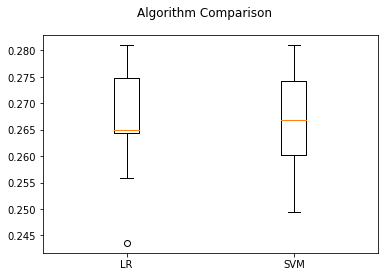

In [145]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [146]:
# Make predictions on validation dataset
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
# lr = LogisticRegression()
# lr.fit(X_train, Y_train)
# predictions = lr.predict(X_validation)
print(predictions)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

[ 5 10  5 ... 30 75 15]
0.22238837855159155
[[  0   6   4 ...   0   0   0]
 [  2  45 159 ...   0   0   0]
 [  3  94 760 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        11
          5       0.14      0.18      0.16       244
         10       0.33      0.69      0.45      1100
         15       0.17      0.16      0.17       645
         20       0.15      0.14      0.14       630
         25       0.06      0.03      0.04       263
         30       0.09      0.05      0.07       382
         35       0.03      0.01      0.02       187
         40       0.05      0.02      0.02       181
         45       0.00      0.00      0.00        98
         50       0.10      0.03      0.05       147
         55       0.00      0.00      0.00        60
         60       0.07      0.02      0.03        92
         65       0.0

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Conclusion
#### bla bla bla